In [3]:
import torch
import numpy as np
from shapely.plotting import plot_polygon

import matplotlib.pyplot as plt
import matplotlib.style as style

style.use(
    "https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle"
)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Cmap with only blue and deacreasig alpha
blue_cmap = LinearSegmentedColormap.from_list(
    "mycmap",
    [
        "cornflowerblue",
        "mediumblue",
    ],
)
blue_cmap = blue_cmap(np.arange(blue_cmap.N))
blue_cmap[:, -1] = np.linspace(0, 1, blue_cmap.shape[0]) * 0.7
# blue_cmap[:, :3] = [0.0, 0.0, 1.0]
blue_cmap = ListedColormap(blue_cmap)

red_cmap = LinearSegmentedColormap.from_list(
    "mycmap",
    [
        "salmon",
        "firebrick",
    ],
)
red_cmap = red_cmap(np.arange(red_cmap.N))
red_cmap[:, -1] = np.linspace(0, 1, red_cmap.shape[0]) * 1.0
# red_cmap[:, :3] = [1.0, 0.0, 0.0]
red_cmap = ListedColormap(red_cmap)

In [4]:
from dased.layout import DASLayout
from dased.optimisation import DASOptimizationProblem, DASArchipelago

In [5]:
from cdv_setup import (
    topo_data,
    prior_dist,
    prior_grid,
    test_geometry,
    design_space_full,
    x,
    y,
    obstacles,
    full_area,
    tomo_roi,
    existing_geometry,
)

# Source Location

In [6]:
from dased.helpers.srcloc import (
    MagnitudeRelation,
    ForwardHomogeneous,
    DataLikelihood,
)

from dased.criteria import (
    EIGCriterion,
)

In [7]:
reference_distance_loc = 1000.0

f_max = 10.0  # Hz

# Magnitude relations for P and S waves
distance_relation_P = MagnitudeRelation(
    log_coeff=-2,
    reference_distance=reference_distance_loc,
)
distance_relation_S = MagnitudeRelation(
    log_coeff=-2, reference_relation=distance_relation_P
)

# Forward models for P and S waves
forward_function_P = ForwardHomogeneous(
    velocity=2500,
    wave_type="P",
    distance_relation=distance_relation_P,
    incidence_max=np.deg2rad(30),
)
forward_function_S = ForwardHomogeneous(
    velocity=1500,
    wave_type="S",
    distance_relation=distance_relation_S,
    incidence_max=np.deg2rad(30),
)

std_corr=0.05
std_uncorr=0.05

# Data likelihoods for P, S, and joint PS
data_likelihood_P = DataLikelihood(
    forward_function=dict(P=forward_function_P),
    std_corr=std_corr,
    std_uncorr=std_uncorr,
    # cor_length=100.0,
    f_max=f_max,
)
data_likelihood_S = DataLikelihood(
    forward_function=dict(S=forward_function_S),
    std_corr=std_corr,
    std_uncorr=std_uncorr,
    # cor_length=100.0,
    f_max=f_max,
)
data_likelihood_PS = DataLikelihood(
    forward_function=dict(P=forward_function_P, S=forward_function_S),
    std_corr=std_corr,
    std_uncorr=std_uncorr,
    # cor_length=100.0,
    f_max=f_max,
)

torch.manual_seed(0)  # For reproducibility
prior_samples = prior_dist.sample((1000,))


eig_p = EIGCriterion(
    prior_samples[:1000],
    data_likelihood=data_likelihood_P,
    eig_method="NMC",
    N=1000,
    downsample=10,
)
eig_s = EIGCriterion(
    prior_samples[:1000],
    data_likelihood=data_likelihood_S,
    eig_method="NMC",
    N=1000,
    downsample=10,
)
eig_ps = EIGCriterion(
    prior_samples[:1000],
    data_likelihood=data_likelihood_PS,
    eig_method="NMC",
    N=1000,
    downsample=10,
)

In [8]:
cable_properties = {
    "elevation": topo_data,
    "cable_length": 1700,
    "spacing": 10, #downsampled later
    "fixed_points": np.array([[1570, 1330]]),
    "N_knots": 12,
    "k": 1,
    "signal_decay": 0.4,
}

optimisation_properties_p = {
    "bounds": [
        [design_space_full.bounds[0], design_space_full.bounds[2]],
        [design_space_full.bounds[1], design_space_full.bounds[3]],
    ],
    "spatial_constraints": design_space_full.envelope.difference(design_space_full),
}

In [9]:
test_cable_p = DASLayout(
    test_geometry, spacing=cable_properties["spacing"], k=1, elevation=topo_data
)
existing_cable = DASLayout(
    existing_geometry, spacing=cable_properties["spacing"], k=1, elevation=topo_data
)

In [10]:
##############################################################################
##############################################################################
############### THIS HAS TO BE FIRST PLOT IN THE NOTEBOOK
############### OTHERWISE IT WILL NOT WORK, FOR SOME REASON
##############################################################################
##############################################################################

from interactive_proposal import select_points

proposal_points = select_points(
    design_space=design_space_full,
    cable_properties=cable_properties,
    filename="data/optimisation/proposal_points_single_eigp.pkl",
)

##############################################################################
############### IF THIS IS CALLED IT WILL NOT WORK AGAIN
############### BUT IT IS NEEDED TO HAVE LATE PLOTS DISPLAYED
##############################################################################

%matplotlib inline

Loaded precomputed points from data/optimisation/proposal_points_single_eigp.pkl


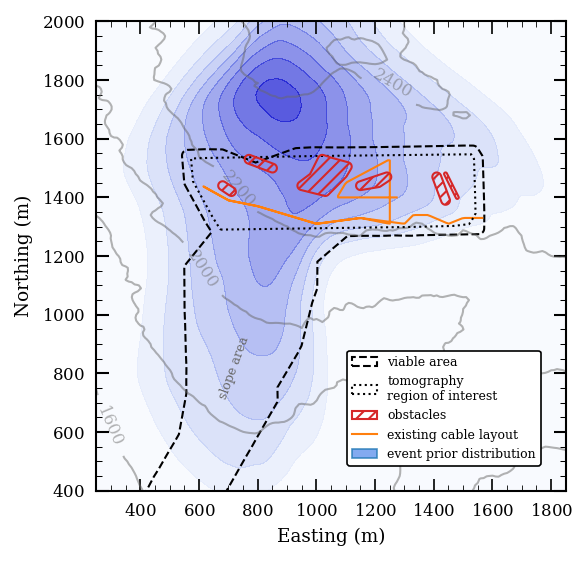

In [11]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plot the prior distribution
prior_plot = ax.contourf(
    x,
    y,
    prior_grid.T,
    levels=8,
    cmap=blue_cmap,
    zorder=-1,
)

plot_polygon(
    full_area,
    ax=ax,
    facecolor="none",
    edgecolor="k",
    linestyle="--",
    linewidth=1.0,
    label="viable area",
    add_points=False,
)
# plot_polygon(
#     design_space_full, ax=ax, facecolor='k', edgecolor='k',
#     linestyle='--', linewidth=1.5, alpha=0.1, add_points=False)
plot_polygon(
    tomo_roi,
    ax=ax,
    facecolor="none",
    edgecolor="k",
    hatch_linewidth=1.0,
    linestyle=":",
    linewidth=1.0,
    zorder=10,
    label="tomography\nregion of interest",
    add_points=False,
)
# plot_polygon(
#     shoulder_area, ax=ax, facecolor='k', edgecolor='k',
#     linestyle=':', linewidth=1.5, alpha=0.1, add_points=False)

# ax.plot([], [], color='blue', label='event prior distribution', alpha=0.8)

for i, obstacle in enumerate(obstacles.geoms):
    plot_polygon(
        obstacle,
        ax=ax,
        facecolor="none",
        edgecolor="tab:red",
        linestyle="-",
        linewidth=1.0,
        label="obstacles" if i == 0 else "",
        add_points=False,
        zorder=10,
        hatch="////",
        hatch_linewidth=1.0,
    )

# Plot the topography as a colormapped background
contour = ax.contour(
    topo_data.x,
    topo_data.y,
    topo_data.values.T,
    colors="dimgray",
    alpha=0.5,
    levels=[1600, 1800, 2000, 2200, 2400, 2600],
    linewidths=1.0,
)
ax.clabel(contour, inline=True, fontsize=8, fmt="%1.0f")

ax.set_aspect("equal")
# Customize plot
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")


# text shoulder area
ax.text(
    720,
    820,
    "slope area",
    fontsize=6,
    color="dimgrey",
    rotation=70,
    ha="center",
    va="center",
)

# plot the existing cable layout
existing_cable.plot(
    ax=ax,
    plot_style="line",
    zorder=5,
    color="tab:orange",
    linewidth=1.0,
    linestyle="-",
    label="existing cable layout",
)

prior_handle = plt.Rectangle(
    [0, 0],
    1,
    1,
    facecolor="cornflowerblue",
    edgecolor="tab:blue",
    alpha=0.8,
    label="event prior distribution",
)

ax.add_artist(prior_handle)

ax.legend(loc="lower right", facecolor="white", edgecolor="black", fontsize=6)

fig.savefig("figures/cdv_setup.png", dpi=300, bbox_inches="tight")
fig.savefig("figures/cdv_setup.pdf", dpi=300, bbox_inches="tight")

ax.set_xlim(250, 1850)
ax.set_ylim(400, 2000)

plt.tight_layout()
plt.show()

In [12]:
udp = DASOptimizationProblem(
    eig_p,
    verbose=0,
    **cable_properties,
    **optimisation_properties_p,
)

archipelago = DASArchipelago(udp, n_islands=16, population_size=128, verbose=0)

archipelago.initialize(
    proposal_points=proposal_points,
    perturb_proposal=50.0,
    perturb_knots=25.0,
    corr_len=500,
    corr_str=0.8,
    min_length=1000,
    show_progress=True,
    filename="data/optimisation/initial_population_single_p",
)

Logging level: WARNING


In [13]:
# initial_layouts = archipelago.get_current_layouts()

# lengths = [_l.cable_length for _l in initial_layouts]

# fig, ax = plt.subplots(figsize=(6, 3))

# ax.hist(
#     lengths,
#     bins=20,
#     color="cornflowerblue",
#     alpha=0.8,
#     edgecolor="black",
#     linewidth=1.2,
# )

# ax.set_xlabel("Cable length [m]")
# ax.set_ylabel("Count")
# ax.set_title("Initial cable lengths")

# plt.tight_layout()
# plt.show()

In [14]:
# from shapely.affinity import translate

# fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# plot_polygon(
#     full_area,
#     ax=ax,
#     facecolor="none",
#     edgecolor="k",
#     linestyle="--",
#     linewidth=1.0,
#     label="viable area",
#     add_points=False,
# )


# for i, obstacle in enumerate(obstacles.geoms):
#     plot_polygon(
#         obstacle,
#         ax=ax,
#         facecolor="none",
#         edgecolor="tab:red",
#         linestyle="-",
#         linewidth=1.0,
#         label="obstacles" if i == 0 else "",
#         add_points=False,
#         zorder=10,
#         hatch="////",
#         hatch_linewidth=1.0,
#     )

# fixed_point = cable_properties["fixed_points"][0]

# # Plot proposal points with tab10 colormap
# tab10 = plt.get_cmap("managua", 10)  # Use viridis colormap for better visibility
# for i, pp in enumerate(proposal_points):
#     pp = np.array(pp)
#     # Prepend the fixed point as the first point
#     pp_with_fixed = np.vstack([fixed_point, pp])
#     color = tab10(i % 10)
#     ax.plot(
#         pp_with_fixed[:, 0],
#         pp_with_fixed[:, 1],
#         "o--",
#         markersize=3,
#         color=color,
#         linewidth=0.8,
#         label="proposal points" if i == 0 else "",
#     )

# # Plot fixed points
# ax.plot(
#     fixed_point[0],
#     fixed_point[1],
#     "P",
#     color="tab:red",
#     markersize=4,
#     label="fixed point",
# )
# ax.plot(
#     fixed_point[0] + 550,
#     fixed_point[1] - 400,
#     "P",
#     color="tab:red",
#     markersize=4,
# )

# # Shift the design space by [100, -100] for illustration

# full_area_shifted = translate(full_area, xoff=550, yoff=-400)

# plot_polygon(
#     full_area_shifted,
#     ax=ax,
#     facecolor="none",
#     edgecolor="k",
#     linestyle="--",
#     linewidth=1.0,
#     add_points=False,
# )

# # Plot initial layouts
# # Select N=500 random initial layouts for plotting
# N = 500
# if len(initial_layouts) > N:
#     idx = np.random.choice(len(initial_layouts), N, replace=False)
#     selected_layouts = [initial_layouts[i] for i in idx]
# else:
#     selected_layouts = initial_layouts

# for layout in selected_layouts:
#     channels = np.array(layout.channel_locations)
#     channels += np.array(
#         [550, -400, 0]
#     )  # Shift channels by [550, -400] for illustration
#     ax.plot(
#         channels[:, 0],
#         channels[:, 1],
#         color="k",
#         alpha=0.1,
#         linewidth=0.5,
#         label="_nolegend_",
#         zorder=-10,
#         linestyle="-",
#     )

# ax.plot([], [], color="k", alpha=0.3, linewidth=1.0, label="initial layouts")

# for i, obstacle in enumerate(obstacles.geoms):
#     obstacle = translate(obstacle, xoff=550, yoff=-400)
#     plot_polygon(
#         obstacle,
#         ax=ax,
#         facecolor="none",
#         edgecolor="tab:red",
#         linestyle="-",
#         linewidth=1.0,
#         add_points=False,
#         zorder=10,
#         hatch="////",
#         hatch_linewidth=1.0,
#     )

# ax.set_aspect("equal")

# # Move legend below plot
# ax.legend(loc="lower left", facecolor="white", edgecolor="black", fontsize=6)


# ax.set_xlim(250, 2200)
# ax.set_ylim(500, 1700)

# ax.set_xticklabels([])
# ax.set_yticklabels([])

# fig.savefig("figures/cdv_initial_layouts.png", dpi=300, bbox_inches="tight")
# fig.savefig("figures/cdv_initial_layouts.pdf", dpi=300, bbox_inches="tight")

# plt.tight_layout()
# plt.show()

In [15]:
archipelago.get_file_info('data/optimisation/optimiser_single_p')

Save file 'data/optimisation/optimiser_single_p.npz' (format v1.0) contains:
- Number of islands: 16
- Population size: 128
- Number of objectives: 1
- Completed generations: 1000
- Algorithms: SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm


"Save file 'data/optimisation/optimiser_single_p.npz' (format v1.0) contains:\n- Number of islands: 16\n- Population size: 128\n- Number of objectives: 1\n- Completed generations: 1000\n- Algorithms: SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm, SGA: Genetic Algorithm"

In [16]:
print(f"EIG_p (existing cable): {eig_p(existing_cable):.2f}")

EIG_p (existing cable): 4.77


In [17]:
archipelago.optimize(
    n_generations=1000,
    migrate_every=20,
    show_progress=True,
    filename="data/optimisation/optimiser_single_p",
)


Evolving islands: 0it [00:00, ?it/s]

In [18]:
best_layout_p = archipelago.get_best_single()[0]

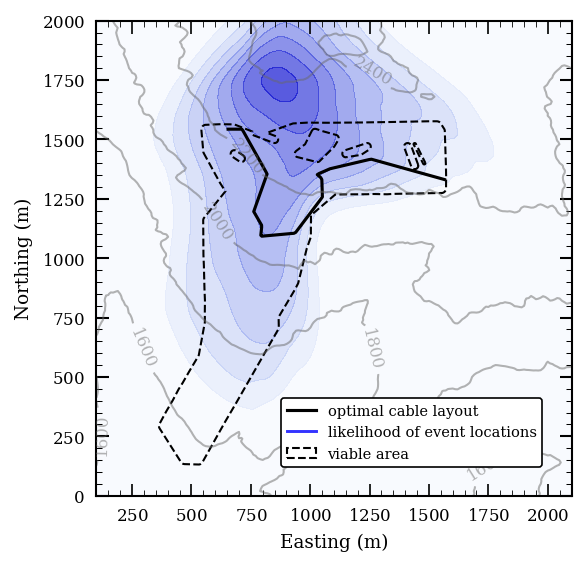

In [19]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plot the prior distribution
prior_plot = ax.contourf(
    x,
    y,
    prior_grid.T,
    levels=8,
    cmap=blue_cmap,
    zorder=-1,
)

best_layout_p.plot(
    ax=ax, plot_style="line", color="k", linewidth=1.5, label="optimal cable layout"
)
ax.plot([], [], color="blue", label="likelihood of event locations", alpha=0.8)

plot_polygon(
    design_space_full,
    ax=ax,
    facecolor="none",
    edgecolor="k",
    linestyle="--",
    linewidth=1.0,
    label="viable area",
    add_points=False,
)
# plot_polygon(
#     design_space_full, ax=ax, facecolor='k', edgecolor='k',
#     linestyle='--', linewidth=1.5, alpha=0.1, add_points=False)
# plot_polygon(
#     shoulder_area, ax=ax, facecolor='none', edgecolor='k',
#     linestyle=':', linewidth=1.5, label='shoulder area', add_points=False)
# plot_polygon(
#     shoulder_area, ax=ax, facecolor='k', edgecolor='k',
#     linestyle=':', linewidth=1.5, alpha=0.1, add_points=False)


# Plot the topography as a colormapped background
contour = ax.contour(
    topo_data.x,
    topo_data.y,
    topo_data.values.T,
    colors="dimgray",
    alpha=0.5,
    levels=[1600, 1800, 2000, 2200, 2400, 2600],
    linewidths=1.0,
)
ax.clabel(contour, inline=True, fontsize=8, fmt="%1.0f")

ax.set_aspect("equal")
# Customize plot
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")


ax.legend(loc="lower right", facecolor="white", edgecolor="black", fontsize=7)

plt.tight_layout()
plt.show()

In [20]:
best_layout_p

DASLayout (Local Coords, 166 channels, 13 anchors, spacing≈10.00m, length=1659.40m, decay=0.40 dB/km, 1 field properties)

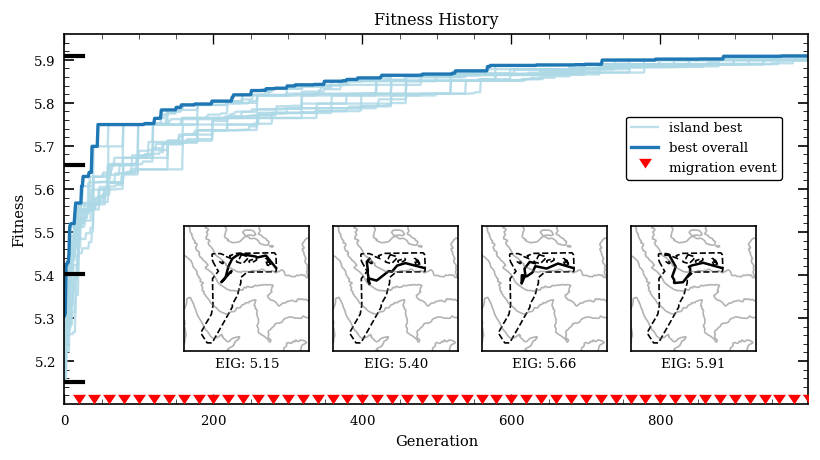

In [21]:
top_layouts, top_fitness = archipelago.get_n_spread_single(4, from_history=True)

fitness_history = archipelago.get_fitness_history()
num_generations = len(fitness_history)

fig = plt.figure(figsize=(8, 4), dpi=120)
gs = fig.add_gridspec(1, 1)
ax_hist = fig.add_subplot(gs[0])
fig.set_facecolor("w")

# fitness_history shape: (n_generations, n_islands)
best_overall = np.max(fitness_history, axis=1)
for i in range(fitness_history.shape[1]):
    ax_hist.plot(
        fitness_history[:, i],
        color="lightblue",
        alpha=0.8,
        label="island best" if i == 0 else None,
    )
ax_hist.plot(best_overall, lw=2, label="best overall", color="tab:blue")

mig_gens = np.arange(
    archipelago.migrate_every, num_generations + 1, archipelago.migrate_every
)
mig_indices = mig_gens[mig_gens <= num_generations]
if mig_indices.size > 0:
    ax_hist.scatter(
        mig_indices,
        [np.min(fitness_history) - 0.05] * len(mig_indices),
        marker=7,
        linewidth=0,
        color="red",
        s=60,
        zorder=5,
        label="migration event",
    )
    ax_hist.set_ylim(bottom=np.min(fitness_history))

ax_hist.set_xlim(left=0, right=num_generations - 1)
ax_hist.set_title("Fitness History")
ax_hist.set_xlabel("Generation")
ax_hist.set_ylabel("Fitness")
ax_hist.legend(loc="upper right", bbox_to_anchor=(1, 0.85))

# Add checkerboard insets, smaller and filling from 0.3 to 1.0 of figure width
inset_width = 0.13
inset_height = 0.3
n_layouts = len(top_layouts)
start = 0.25
end = 1.0
if n_layouts > 1:
    step = (end - start - inset_width) / (n_layouts)
else:
    step = 0
for idx, proposal_layout in enumerate(top_layouts):
    left = start + idx * step
    bottom = 0.2
    ax_inset = fig.add_axes([left, bottom, inset_width, inset_height])
    # criteria_dict['rayleigh_tomo_rer'].plot_checkerboard(
    #     proposal_layout,
    #     sigma_d=1e-2,
    #     correlation_length=200.0,
    #     regularization_weight=1e-5,
    #     ax=ax_inset,
    # )

    proposal_layout.plot(ax=ax_inset, plot_style="line", color="k", linewidth=1.5)
    plot_polygon(
        design_space_full,
        ax=ax_inset,
        facecolor="none",
        edgecolor="k",
        linestyle="--",
        linewidth=1.0,
        label="viable area",
        add_points=False,
    )

    contour = ax_inset.contour(
        topo_data.x,
        topo_data.y,
        topo_data.values.T,
        colors="dimgray",
        alpha=0.5,
        levels=[1600, 1800, 2000, 2200, 2400, 2600],
        linewidths=1.0,
    )

    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.set_aspect("equal")

    ax_inset.set_xlabel(
        f"EIG: {top_fitness[idx]:.2f}",
        fontsize=8,
    )

    ax_hist.axhline(
        top_fitness[idx],
        0,
        0.025,
        color="k",
        linestyle="-",
        linewidth=2.5,
    )

ax_hist.set_ylim(np.min(fitness_history) - 0.05, np.max(fitness_history) + 0.05)

fig.savefig("figures/eig_p_fitness_history.png", bbox_inches="tight", dpi=300)
fig.savefig("figures/eig_p_fitness_history.pdf", bbox_inches="tight", dpi=300)

plt.show()

In [22]:
print(f"EIG_p (existing cable): {eig_p(existing_cable):.2f}")
print(f"EIG_p (test cable): {eig_p(test_cable_p):.2f}")
print(f"EIG_p (best layout): {eig_p(best_layout_p):.2f}")

EIG_p (existing cable): 4.77
EIG_p (test cable): 4.41
EIG_p (best layout): 5.60


Posterior plots:   0%|          | 0/20 [00:00<?, ?it/s]

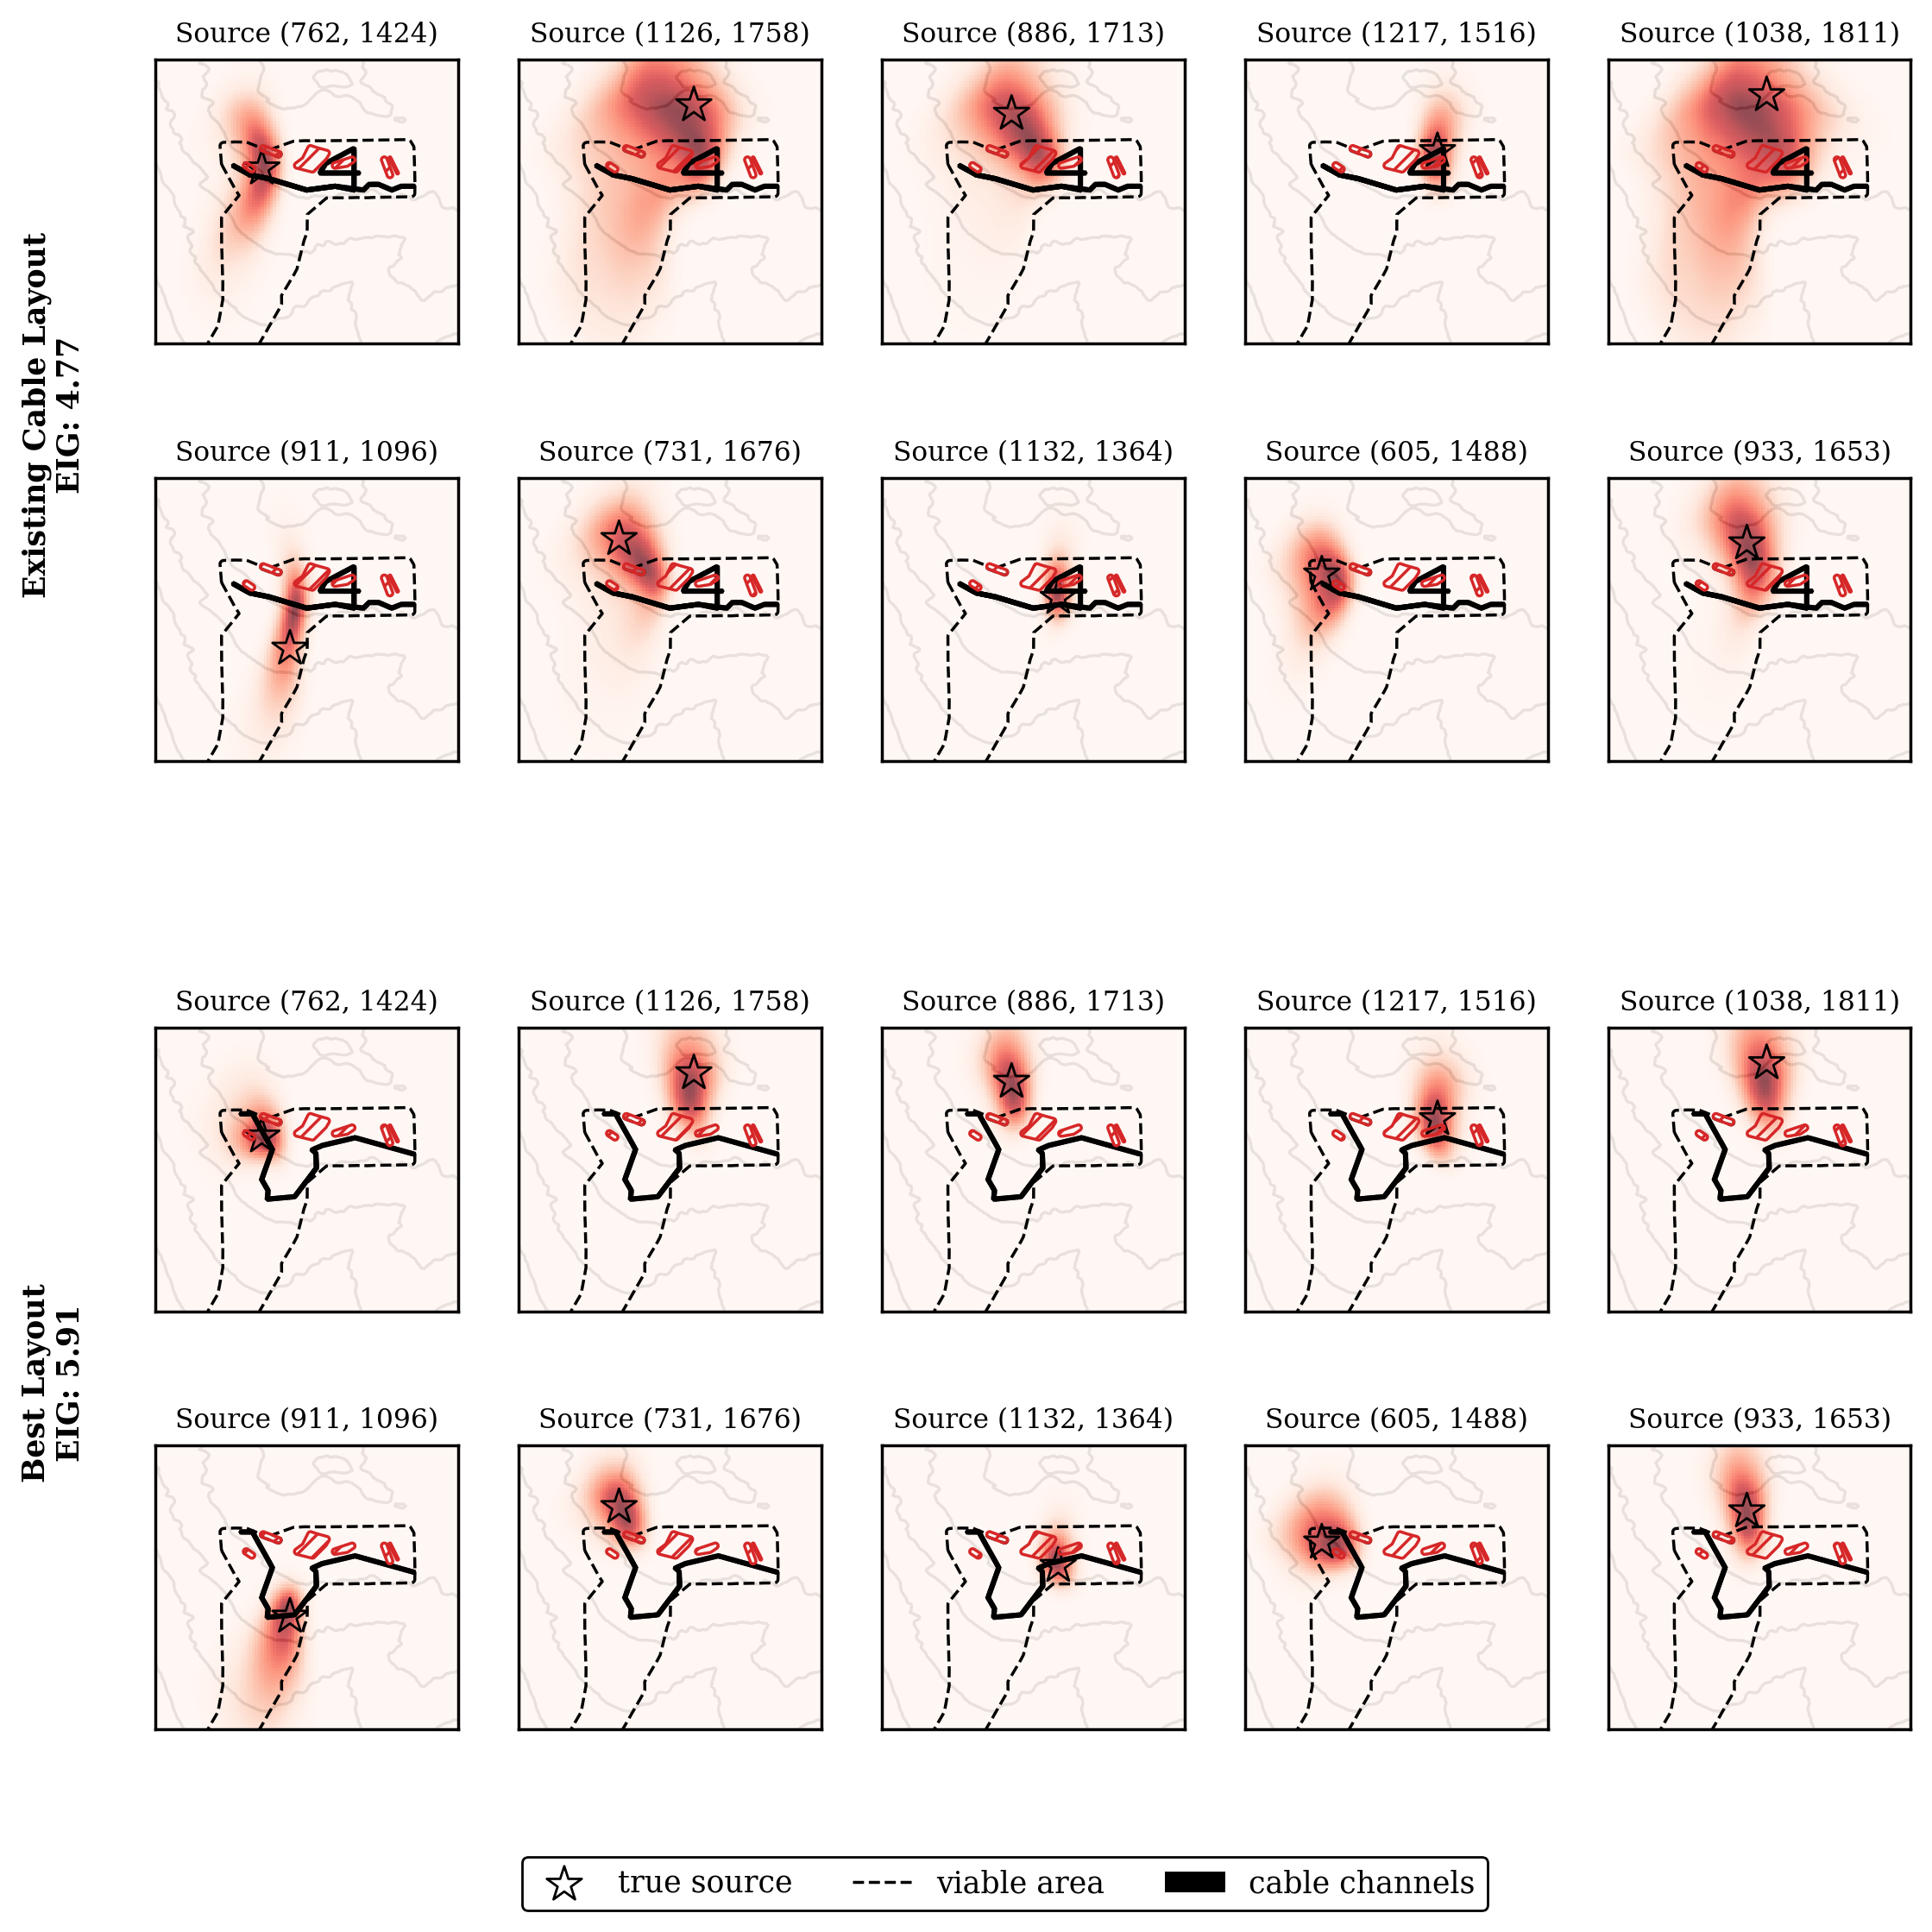

In [28]:
from dased.helpers.srcloc import calculate_posterior
import matplotlib.pyplot as plt
import shapely
from tqdm.auto import tqdm

eig_existing = eig_p(existing_cable)

# true_sources = prior_samples[:20, :][[1, 2, 4, 5, 6, 7, 9, 8, 0]].numpy()

true_sources = prior_samples[:20, :][[1, 2, 5, 7, 9, 10, 13, 15, 16, 18, ]].numpy()

# true_sources = prior_samples[:2, :].numpy()

def plot_posterior(
    ax,
    source,
    design,
    data_likelihood,
    topo_data,
    design_space,
    x_range,
    y_range,
    grid_size=100,
    seed=1,
    downsample=1,
):
    x_posterior, y_posterior, _, log_posterior, post_info = calculate_posterior(
        true_source=torch.tensor(source, dtype=torch.float64),
        design=design.get_gdf(),
        data_likelihood=data_likelihood,
        x_range=x_range,
        y_range=y_range,
        z_range=[source[2] - 100, source[2] + 100],
        grid_size=grid_size,
        prior_dist=prior_dist,
        seed=seed,
        clean_data=True,
        downsample=downsample,
    )
    posterior = log_posterior.exp().mean(dim=-1).numpy()

    # Plot topography
    contour = ax.contour(
        topo_data.x,
        topo_data.y,
        topo_data.values.T,
        colors="dimgray",
        alpha=0.5,
        levels=[1600, 1800, 2000, 2200, 2400, 2600],
        linewidths=1.0,
    )
    # Plot the posterior distribution
    ax.pcolormesh(
        x_posterior,
        y_posterior,
        posterior.T,
        shading="auto",
        cmap="Reds",
        alpha=0.7,
        zorder=2,
        rasterized=True,
    )
    # Plot the true source location
    ax.scatter(
        source[0],
        source[1],
        marker="*",
        s=150,
        edgecolor="black",
        # facecolor="yellow",
        facecolor="none",
        zorder=5,
        label="true source",
    )
    # Plot the design space boundary
    ax.plot(
        *shapely.geometry.polygon.Polygon(design_space_full).exterior.xy,
        "k--",
        linewidth=1,
        label="viable area",
    )
    # Plot the cable layout
    design.plot(
        ax=ax,
        plot_style="channels",
        zorder=4,
        color="k",
        width=0.02,
        alpha=1.0,
        label="cable channels",
    )
    # Set plot limits and aspect
    ax.set_xlim(*x_range)
    ax.set_ylim(*y_range)
    ax.set_aspect("equal")

# Use the same x/y range for all plots
x_range = (100, 2200)
y_range = (0, 2100)
data_likelihood = data_likelihood_P

layouts = [existing_cable] + top_layouts

n_sources = len(true_sources)
n_layouts = len(layouts)

# Option to plot all layouts or only existing vs best
plot_all = False  # Set to True to plot all layouts

if plot_all:
    selected_layouts = layouts
else:
    selected_layouts = [layouts[0], layouts[-1]]  # Existing vs best layout

n_selected_layouts = len(selected_layouts)

# Use 2 rows per layout
rows_per_layout = 2
sources_per_row = n_sources // rows_per_layout

# Create mosaic layout with dummy rows for spacing
mosaic_layout = []
for layout_idx in range(n_selected_layouts):
    # Add two rows for this layout
    for row_in_layout in range(rows_per_layout):
        row_key = f"layout_{layout_idx}_row_{row_in_layout}"
        mosaic_layout.append([f"{row_key}_{col}" for col in range(sources_per_row)])
    
    # Add dummy row for spacing (except after last layout)
    if layout_idx < n_selected_layouts - 1:
        mosaic_layout.append([f"dummy_{layout_idx}"] * sources_per_row)

# Create figure with subplot mosaic
fig, axes = plt.subplot_mosaic(
    mosaic_layout,
    figsize=(
        (x_range[1] - x_range[0]) / 1000 * sources_per_row, 
        (y_range[1] - y_range[0]) / 1000 * len(mosaic_layout)
    ),
    dpi=250,
    gridspec_kw={'height_ratios': [1 if 'dummy' not in row[0] else 0.2 for row in mosaic_layout]}
)
fig.set_facecolor("w")

# Hide dummy axes
for key in axes.keys():
    if 'dummy' in key:
        axes[key].set_visible(False)
        tasks_per_layout = min(rows_per_layout * sources_per_row, n_sources)
        total_tasks = n_selected_layouts * tasks_per_layout
        pbar = tqdm(total=total_tasks, desc="Posterior plots")

        for layout_idx, layout in enumerate(selected_layouts):
            for row_in_layout in range(rows_per_layout):
                for col in range(sources_per_row):
                    source_idx = row_in_layout * sources_per_row + col
                    if source_idx >= n_sources:
                        continue
                        
                    source = true_sources[source_idx]
                    ax_key = f"layout_{layout_idx}_row_{row_in_layout}_{col}"
                    ax = axes[ax_key]
                    
                    plot_posterior(
                        ax=ax,
                        source=source,
                        design=layout,
                        data_likelihood=data_likelihood,
                        topo_data=topo_data,
                        design_space=design_space_full,
                        x_range=(200, 1800),
                        y_range=(500, 2000),
                        grid_size=(100, 100, 10),
                        downsample=10,
                        seed=source_idx + 1,
                    )

                    for i, obstacle in enumerate(obstacles.geoms):
                        plot_polygon(
                            obstacle,
                            ax=ax,
                            facecolor="none",
                            edgecolor="tab:red",
                            linestyle="-",
                            linewidth=1.0,
                            add_points=False,
                            zorder=10,
                            hatch="////",
                            hatch_linewidth=1.0,
                        )

                    ax.set_title(f"Source ({int(source[0])}, {int(source[1])})", fontsize=9)
                    
                    # Remove labels and ticks
                    ax.set_ylabel("")
                    ax.set_xlabel("")
                    ax.set_xlim(200, 1800)
                    ax.set_ylim(500, 2000)
                    ax.set_xticks([])
                    ax.set_yticks([])

                    pbar.update(1)

        pbar.close()

# Add text labels for each layout
for layout_idx, layout in enumerate(selected_layouts):
    if layout_idx == 0:
        text = f"Existing Cable Layout\nEIG: {eig_existing:.2f}"
    else:
        text = f"Best Layout\nEIG: {top_fitness[-1]:.2f}"
    
    # Position text on the left side of the first subplot in each layout
    first_ax_key = f"layout_{layout_idx}_row_0_0"
    ax_pos = axes[first_ax_key].get_position()
    
    fig.text(
        0.08,  # x position (left edge)
        ax_pos.y0 - ax_pos.height / 4,  # y position (middle of first row)
        text,
        rotation=90,
        verticalalignment='center',
        horizontalalignment='center',
        fontsize=10,
        weight='bold'
    )

# Add legend at the bottom
first_ax_key = "layout_0_row_0_0"
handles, labels = axes[first_ax_key].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.02),
    ncol=5,
    facecolor="white",
    edgecolor="black",
    fontsize=10,
)

fig.savefig("figures/eig_p_posterior_plots.png", bbox_inches="tight", dpi=250)
fig.savefig("figures/eig_p_posterior_plots.pdf", bbox_inches="tight", dpi=250)

plt.show()


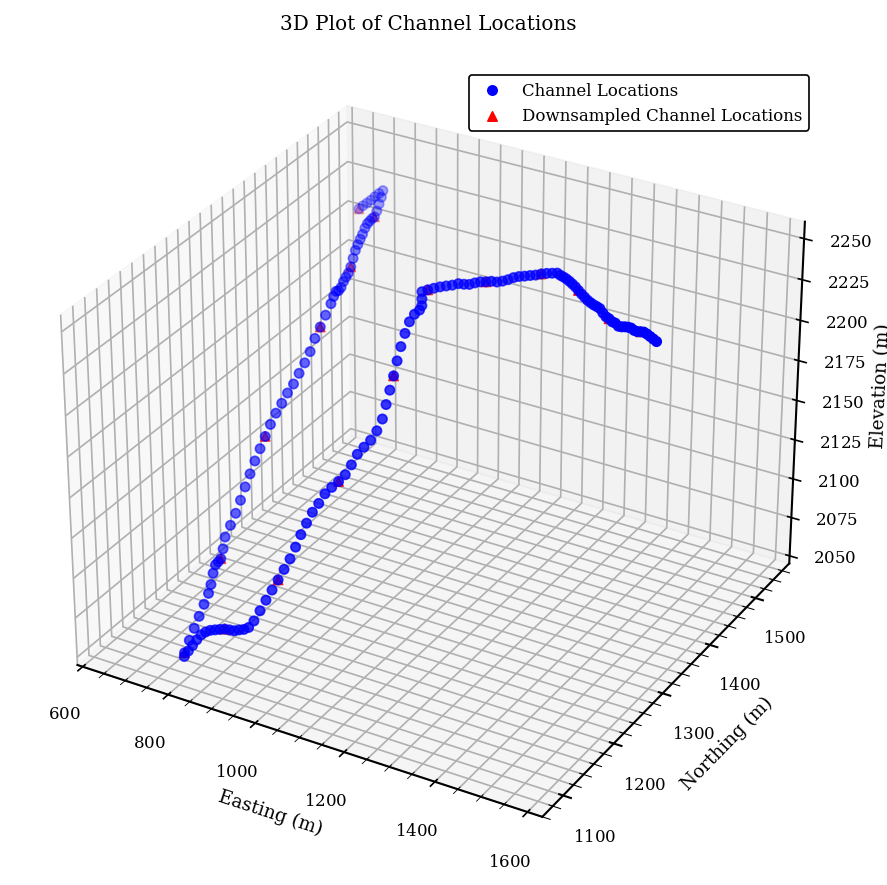

In [24]:
%matplotlib inline

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the channel locations
ax.scatter(
    best_layout_p.channel_locations[:, 0],
    best_layout_p.channel_locations[:, 1],
    best_layout_p.channel_locations[:, 2],
    c='blue', marker='o', label='Channel Locations')

ax.scatter(
    best_layout_p.channel_locations[5::10, 0],
    best_layout_p.channel_locations[5::10, 1],
    best_layout_p.channel_locations[5::10, 2],
    c='red', marker='^', label='Downsampled Channel Locations')

# Customize the plot
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_zlabel('Elevation (m)')
ax.set_title('3D Plot of Channel Locations')
ax.legend()

plt.tight_layout()
plt.show()